In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, scale
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>

# Traits and Range Shifts <small>work by [Tony Cannistra](http://www.github.com/acannistra) and the [Buckley Lab](http://faculty.washington.edu/lbuckley) at the University of Washington</small>

We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

This document proceeds in 3 parts. First we establish an evaluation framework which we can use to compare various methods of elucidating the relationships between various predictors and range shifts. We next bring in some statistical analyses to assist in selecting the set of predictors most likely to influence our response variable. Finally we present a selection of regression techniques and evaluate them on their ability to recover range shift information. 

## Part 1: Evaluation Techniques

### Cross Validation 

For some regression techinques outlined below, it is possible to use the coefficient of determination ($R^2$) to evaluate an algorithms regression performance in terms of explained variance. The use of $R^2$ is problematic in several ways though, namely that a high value does not indicate a model with high predictive power, especially when many of the techniques herein are prone to over-fitting. For most of the techniques presented here we will use **cross validation** to examine the regressor's ability to predict range shifts. 

Cross validation is a nice method for doing feature/parameter selection and also for selecting degrees of freedom in nonparametric models––we'll need both here. 

The Python module [`scikit-learn`]() presents a wealth of cross-validation tools which we include below, namely:
* [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) which computes a random split into testing and training sets
* [`LeaveOneOut`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut) more efficiently uses the data as it creates $n$ training and test sets, where the test sets contain only a single element
* `LeavePOut` which is the same as `LeaveOneOut`, except that the number to leave out of the training set can be specified. 

In [3]:
from sklearn.model_selection import train_test_split,\
                                    LeaveOneOut,\
                                    LeavePOut,\
                                    KFold,\
                                    cross_val_score



We use the `cross_val_score` function together with the cross validation as such: 

    cross_val_score(regressor, train, test, cv=LeaveOneOut(), scoring='neg_mean_squared_error')


### Aikake's Information Criterion (AIC) 
The AIC is defined as $$AIC = -2 \log \mathcal{L} + 2p$$ where $\mathcal{L}$ is the maximized likelihood using **all available** data for estimtion and $p$ is the number of free parameters in the model. *Minimizing AIC is equivalent to minimizing CV value in the asymptote* and this is true for all models [(Stone 1977)](http://www.jstor.org/stable/2984877), not just linear ones. This makes AIC useful in comparing models. It will take some work to create this metric for some of our models, but we will work on it. 

---
## Part 2: The Data

The next step here is to get a better idea of what the data look like. Much of this work has already been done and is replicated here. The original work can be seen in the [`./experiments`](./experiments) folder and in the [`Statistical Analysis (Alpine Plants).ipynb`]() file (if you're running this notebook on your computer, those links will work. ). All important parts are here, though. 

*A note on the data*: These data come from [Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract). They contain various trait information for North American birds, Yosemite mammals, Swiss Alpine plants, and dragonflies. By far the largest and most trait-rich data set is the Swiss Alpine plants dataset, so we begin there. 

### Multiple Versions
We create several different versions of the dataset based on different preprocessing regimes. They are:

0. We leave the data as-is, with missing values and categorical variables. 
1. We remove rows that are missing values for any trait value and encode categorical variables with one-hot binary encoding.
2. We remove traits which are missing values for any taxon and encode categorical varaibles with one-hot binary encoding
3. We interpolate missing values (see below for technique) and encode categorical variables with one-hot binary encoding. 
4. We remove categorical variables and remove rows that are missing values. 
5. Keep all rows/cols with missing values, perform one-hot encoding on categorical variables.

For all of these transformations we remove predictor variables derived from the response variable.

In [4]:
Data = {} ## master dictionary containing all data transformations

responseVar = "migration_m"

plants_master = pd.read_csv("../data/plants5.csv")


drop_features = ["Taxon",
                 "migr_sterr_m", 
                 "shift + 2SE", 
                 'signif_shift',
                 "signif_shift2",
                 "dispmode01",
                 "DispModeEng", ## what is this
                 "shift + 2SE",
                ]

categorical_features = ["oceanity",
                        "dispersal_mode",
                        "BreedSysCode",
                        "Grime"]

In [5]:
##
# We leave the data as-is, with missing values and categorical variables.
##

x_tmp = plants_master.drop(drop_features, axis=1)
y_tmp = x_tmp[responseVar]
x_tmp.drop([responseVar], axis=1)
Data["as-is"] = (x_tmp, y_tmp)


In [56]:
## 
#  We remove rows that are missing values for any trait value and encode categorical variables
#  with one-hot binary encoding.
##

# one-hot encoding for categorical features:
plants = pd.get_dummies(plants_master, columns=categorical_features)

# drop features we don't want
features = plants.drop(drop_features, axis=1)

# drop features with n/a or NaN
## axis = 1 drops columns with any NAs, axis = 0 drops rows with any NAs
features = features.dropna(axis=0)

# extract response variable from trimmed data
target   = features[responseVar]
features.drop([responseVar], inplace=True, axis=1)
Data["nonan-rows-one-hot"] = (features, target)



In [58]:
##
# We remove traits which are missing values for any taxon and encode categorical varaibles 
# with one-hot binary encoding
##

plants = pd.get_dummies(plants_master, columns=categorical_features)

# drop features we don't want
features = plants.drop(drop_features, axis=1)

# drop features with n/a or NaN
## axis = 1 drops columns with any NAs, axis = 0 drops rows with any NAs
features = features.dropna(axis=1)

# extract response variable from trimmed data
target   = features[responseVar]
features.drop([responseVar], inplace=True, axis=1)
Data["nonan-cols-one-hot"] = (features, target)
print(features.shape)

(133, 26)


In [8]:
##
#  We interpolate missing values (see below for technique) and encode categorical variables 
#  with one-hot binary encoding. 
##

plants = pd.get_dummies(plants_master, columns=categorical_features)
features = plants.drop(drop_features, axis = 1)
features.interpolate(axis=0, method='slinear', inplace=True)
features.dropna(axis=0, inplace=True)
target = features[responseVar]
features.drop([responseVar], axis=1, inplace=True)
Data["interp-onehot"] = (features, target)



In [9]:
##
# We remove categorical variables and remove rows that are missing values. 
##

features = plants_master.drop(drop_features + categorical_features, axis=1)
features = features.dropna(axis=0)
target   = features[responseVar]
features.drop(responseVar, axis=1, inplace=True)
Data['nonan-rows-nocat'] = (features, target)

In [10]:
##
# Keep all rows/cols with missing values, perform one-hot encoding on categorical variables.
##
plants = pd.get_dummies(plants_master, columns=categorical_features)
x_tmp = plants.drop(drop_features, axis=1)
y_tmp = x_tmp[responseVar]
x_tmp.drop([responseVar], axis=1, inplace=True)
Data["onehot"] = (x_tmp, y_tmp)



### Are the traits linear? 
Here we're interested in the linear relationships between all of the predictors in the dataset and all of the predictors and the target variable. 


### Plots
we plot the features versus the target variable `migration_m`

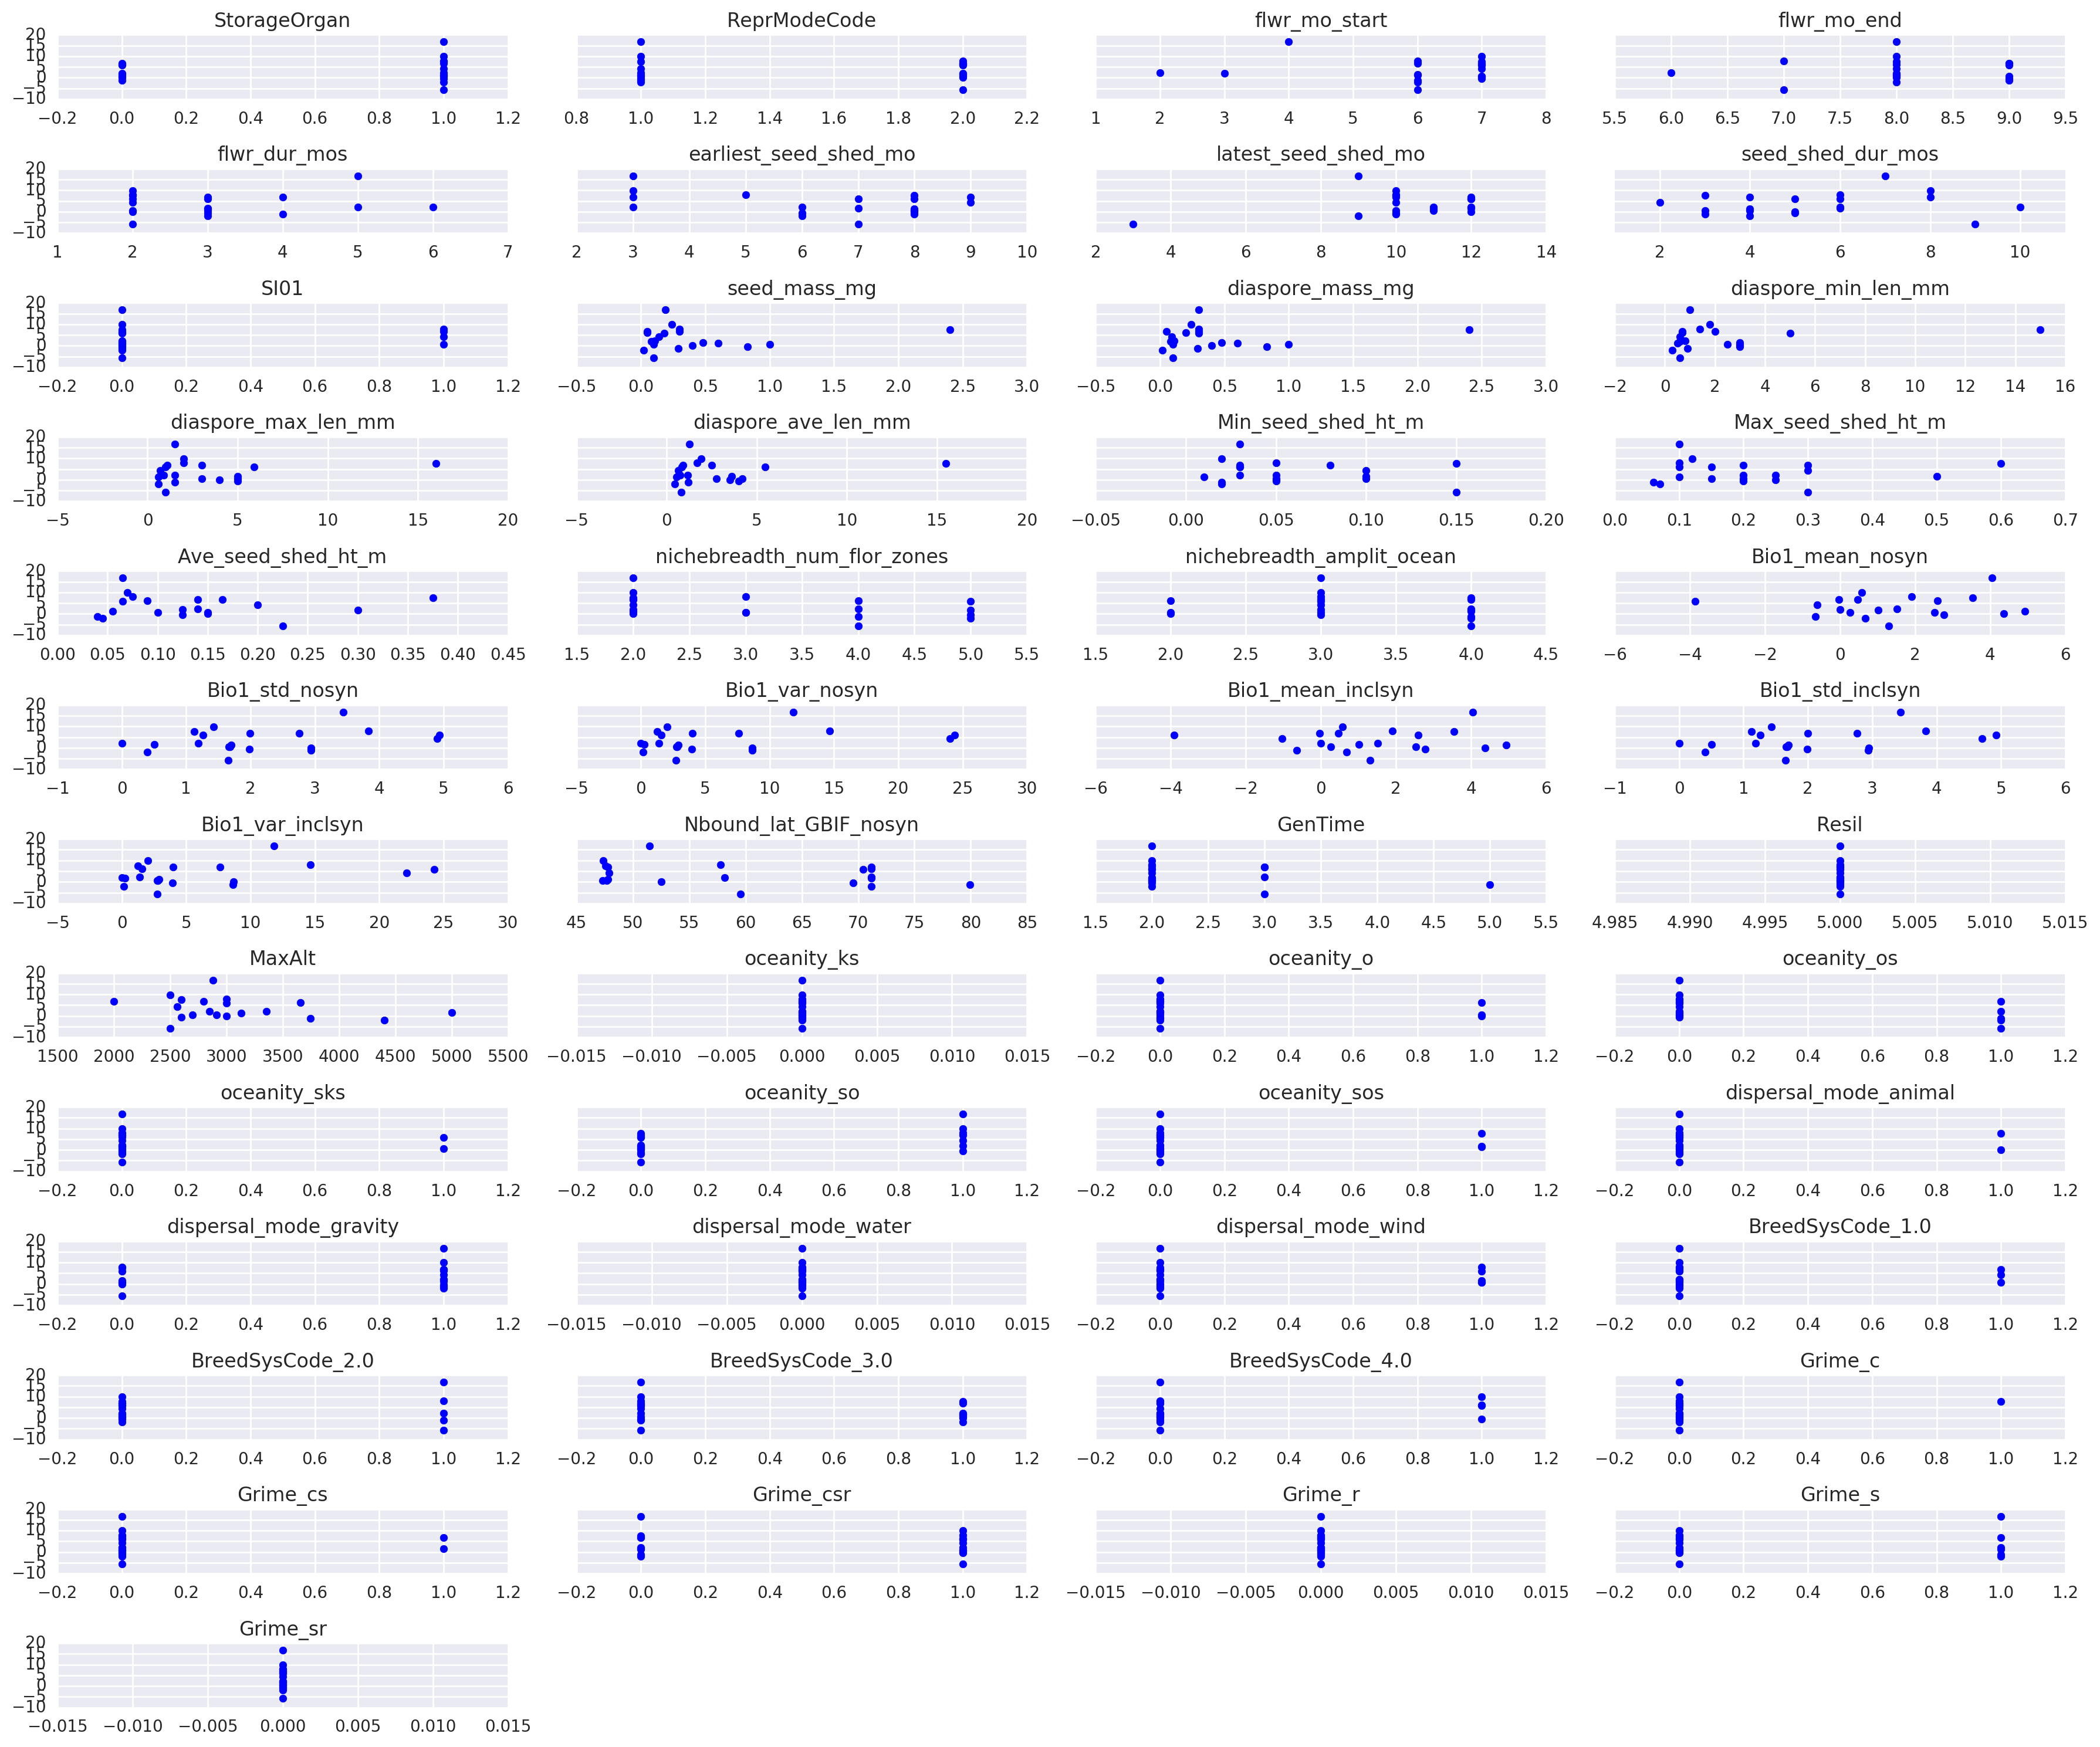

In [12]:
subplotRows = 13
subplotCols = 4

features,target = Data[DATASET]


fig, subplots = plt.subplots(subplotRows,subplotCols, sharey=True)
fig.set_figwidth(18)
fig.set_figheight(15)
featureIter = iter(features.columns)

for row in range(0, subplotRows):
    for col in range(0, subplotCols):
        try:
            feat = next(featureIter)
            X = features[feat].values
            Y = target
            subplots[row, col].scatter(X, Y, color='blue')
            subplots[row, col].set_title(str(feat))
        except StopIteration:
            fig.delaxes(subplots[row,col])
                    

plt.tight_layout()
plt.show()

These plots show that several of the features (`Bio1_mean_nosyn`, `Bio1_var_inclsyn`, `Ave_seed_shed_ht_m`, etc.) could potentially have linear relationships with the target variable, and that many of the variables are either quite nonlinear in their relationships (`Seed_mass_mg`, `diaspore_min_len_mm`) or are categorical.

Taking a more rigorous approach here, we calculate Pearson's correlation coefficient both for all pairs of features (to assess collinearity) and for each feature and the target migration variable. 

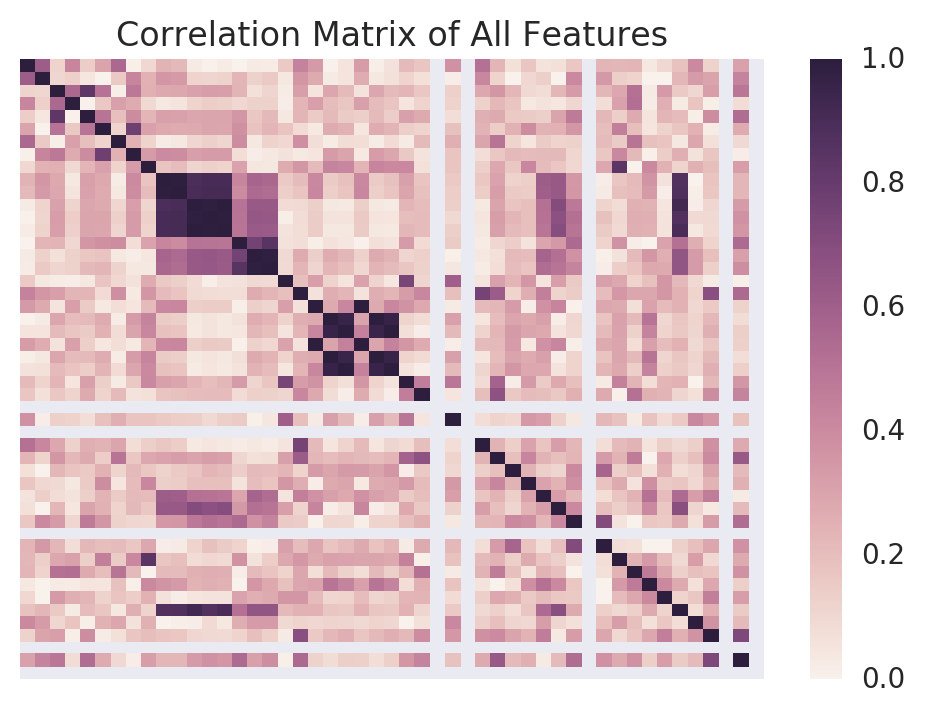

In [13]:
hm = sns.heatmap(Data[DATASET][0].corr().abs())
hm.set(xticklabels=[], yticklabels=[])
hm.set_title("Correlation Matrix of All Features")



The above correlation plot indicates that many of the features covary to significant degrees. This is a challenging problem to overcome for linear regression. 

---
## Part 3) Regression Analysis 




In [215]:
DATASET = "nonan-cols-one-hot"
Results = {}
X, Y = Data[DATASET]

### Decision Tree Regression

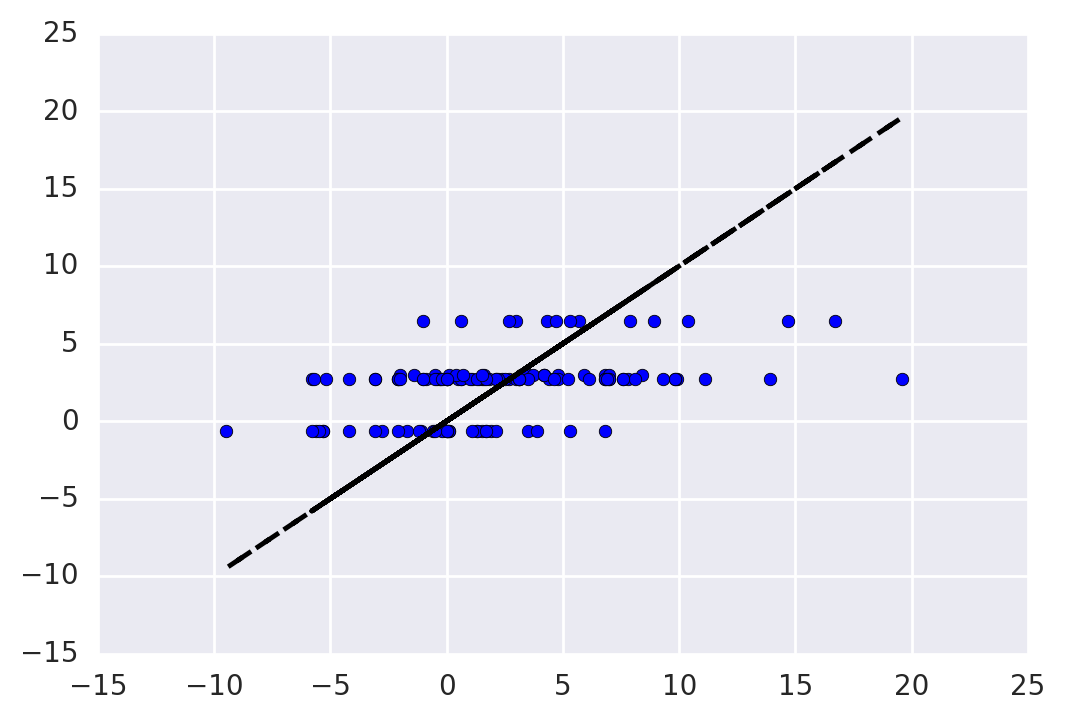

In [219]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth = 2)
err = cross_val_score(reg, scale(X), Y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()
Results["DecisionTree"] = err
reg.fit(scale(X), Y)
plt.scatter(Y, reg.predict(scale(X)))
plt.plot(Y, Y, 'k--')


### Random Forest Regression

-23.3623180451


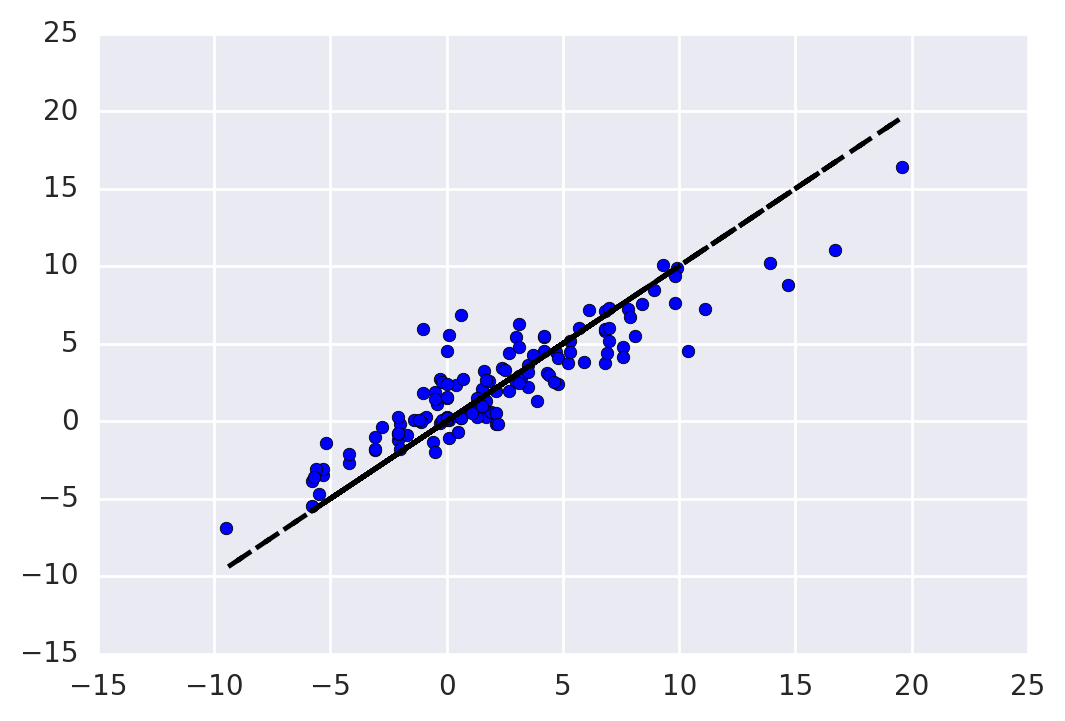

In [220]:
from sklearn.ensemble import RandomForestRegressor


reg = RandomForestRegressor()
err = cross_val_score(reg, scale(X), Y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()
Results["Random Forest"] = err
reg.fit(scale(X), Y)
plt.scatter(Y, reg.predict(scale(X)))
plt.plot(Y, Y, 'k--')
print(err)

### Ridge Regression

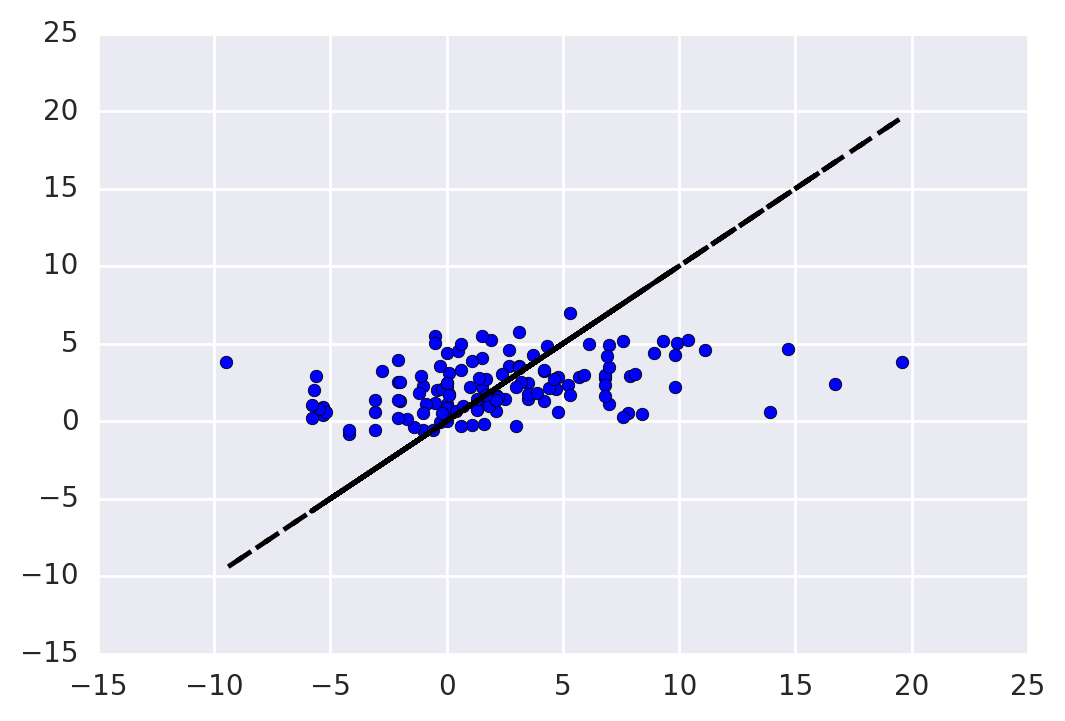

In [221]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1.7)
err = cross_val_score(reg, scale(X), Y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()
Results["Ridge"] = err
reg.fit(scale(X), Y)
plt.scatter(Y, reg.predict(scale(X)))
plt.plot(Y, Y, 'k--')

### Support Vector Regression


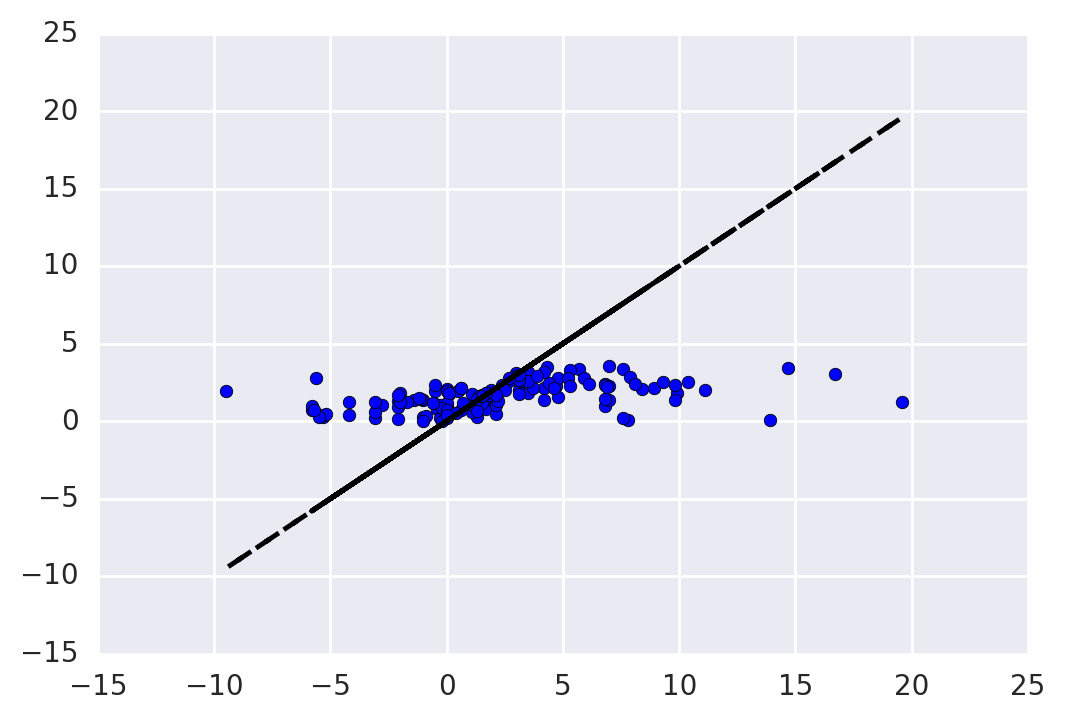

In [222]:
from sklearn.svm import SVR

reg = SVR()
err = cross_val_score(reg, scale(X), Y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()
Results["SVR"] = err
reg.fit(scale(X), Y)
plt.scatter(Y, reg.predict(scale(X)))
plt.plot(Y, Y, 'k--')

### PCA + partial least squares regression

-24.9241993025
-29.5980889271
-29.5980889271
-29.5980889271
-29.5980921371


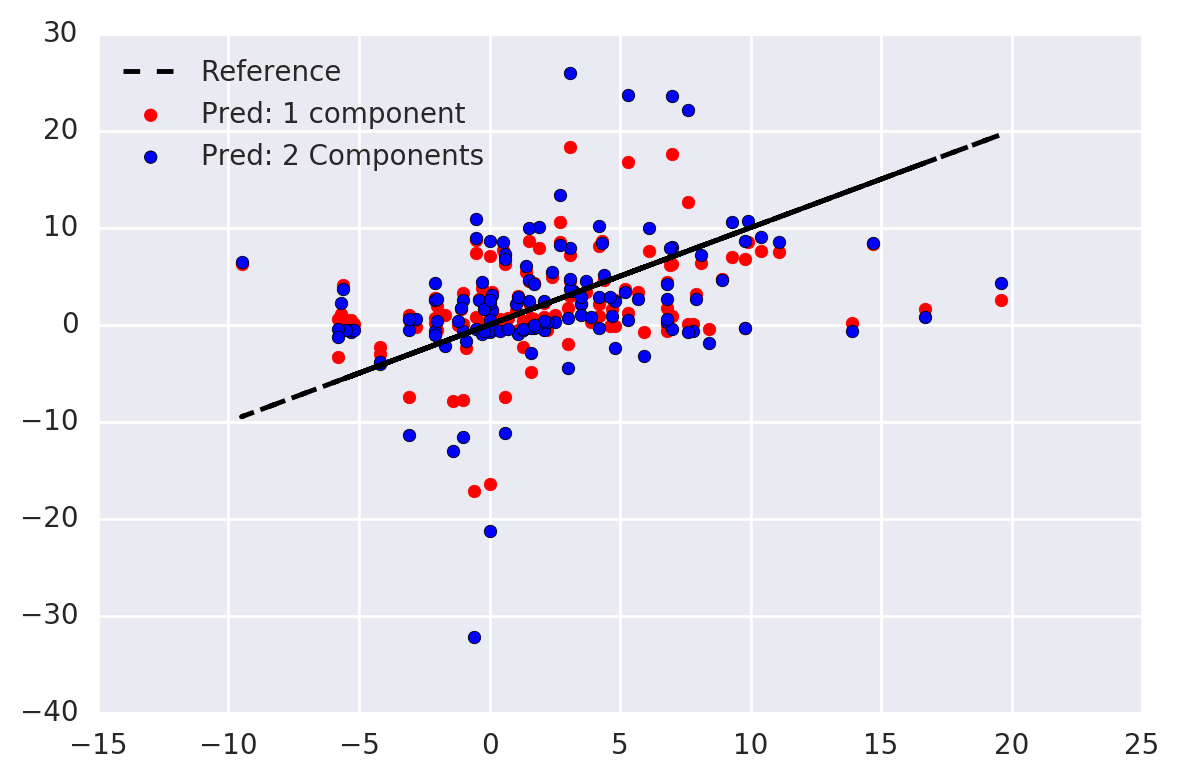

In [223]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

X_reduced = PCA().fit_transform(X)


for i in np.arange(1,6):
    pls = PLSRegression(n_components=i, scale=False)
    pls.fit(scale(X_reduced), Y)
    err = cross_val_score(pls, scale(X_reduced), Y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()
    Results["PLS_"+str(i)] = err
    print(err)

pls1 = PLSRegression(n_components=1, scale=True)
pls2 = PLSRegression(n_components=2, scale=True)
pls1.fit(X, Y) 
pls2.fit(X, Y)
plt.scatter(Y, pls1.predict(X), color='r', label="Pred: 1 component")
plt.scatter(Y, pls2.predict(X), label="Pred: 2 Components")
plt.plot(Y, Y, 'k--', label="Reference")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


## MARS: multivariate adaptive regression splines

This is one of the few methods which can handle NaN values, so we perform this analysis using different interpolation methods and the interpolation method included in MARS. 

In [226]:
from pyearth import Earth

X, Y= Data[DATASET]


regr = Earth(max_degree=1)
err = cross_val_score(regr, X, Y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()
print(err)
Results["MARS_1"] = err


-22.42241026


$R^2$:  0.395594026595
-46.2858112831


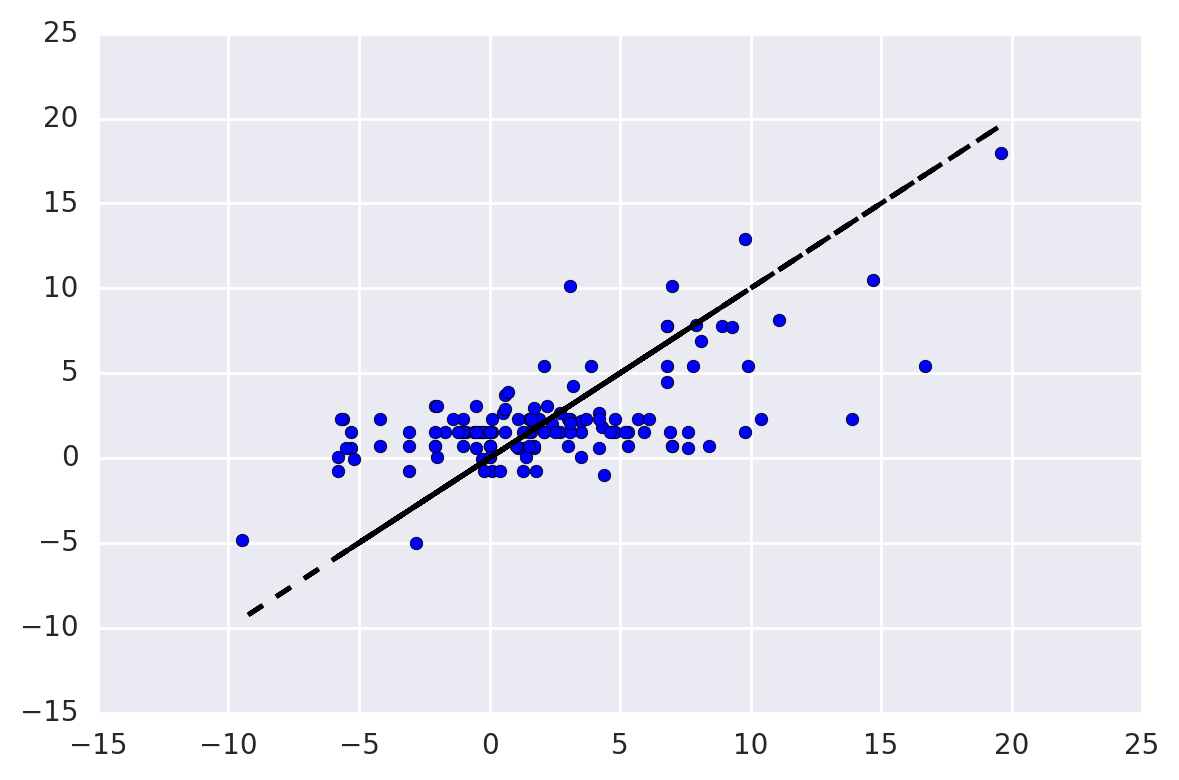

In [225]:
X_nans, Y_nans = Data['onehot']


regr_nans = Earth(max_degree=3, allow_missing=True)
regr_nans.fit(X_nans, Y_nans)
print("$R^2$: ", regr_nans.score(X_nans, Y_nans))
errs = cross_val_score(regr_nans, X_nans, Y_nans, cv=KFold(5), scoring='neg_mean_squared_error')
Results["MARS_3"] = errs.mean()
# np.var(errs)
# np.std(errs)
# plt.title(errs.mean())
# print(regr_nans.summary())
print(errs.mean())
regr_nans.fit(X_nans, Y_nans)
plt.scatter(Y_nans, regr_nans.predict(X_nans))
plt.plot(Y_nans, Y_nans, 'k--')
plt.tight_layout()
plt.show()


## Multilayer perceptron regression (neural network)

-33.9879814735
R^2: 0.817790475826


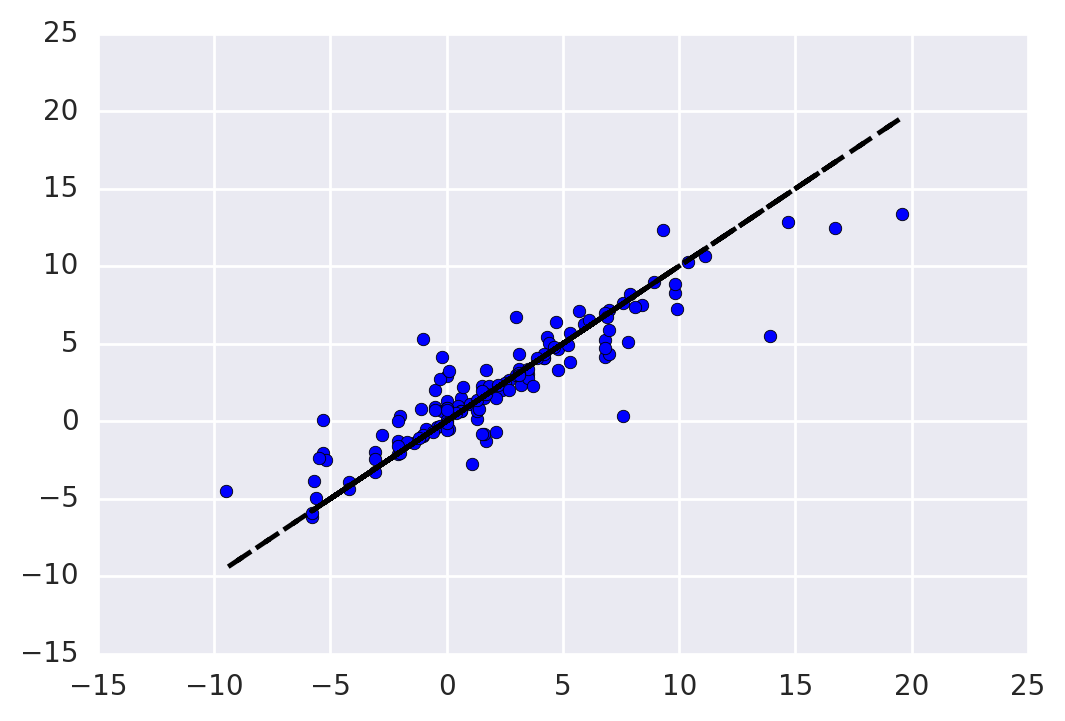

In [236]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(activation='relu', hidden_layer_sizes=(100,100,))

errs = cross_val_score(nn, X, Y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()
print(errs)
Results["MLP"] = errs
nn = MLPRegressor(activation='relu', hidden_layer_sizes=(100,100,))

nn.fit(X, Y)
plt.scatter(Y, nn.predict(X))
plt.plot(Y, Y, 'k--')
nn.n_layers_
print("R^2:", nn.score(X, Y))


Notes on the NN: I tried adding more layers and it really brought up the accuracy in the plot but totally brought it down in the cross-validation. Over-fitting?

In [237]:
import operator
sorted(Results.items(), key=operator.itemgetter(1), reverse=True)

[('MARS', -22.422410259994923),
 ('MARS_1', -22.422410259994923),
 ('SVR', -23.056179174659398),
 ('Random Forest', -23.362318045112783),
 ('DecisionTree', -23.541349877801853),
 ('PLS_1', -24.924199302486809),
 ('Ridge', -27.041176725146936),
 ('PLS_3', -29.598088927076699),
 ('PLS_2', -29.598088927076706),
 ('PLS_4', -29.598088927077374),
 ('PLS_5', -29.59809213712338),
 ('MLP', -33.987981473471223),
 ('MARS_3', -46.285811283107634)]